# Chess Analysis with Stockfish

I play way too much chess, but honestly, I'm terrible. Thinking about the games I've played recently, I would say I do pretty well up until somewhere around the tenth move, then things start to break down. But can I can get a better sense of when I begin to fall apart? Would I be a better player if I could keep it together longer?

### Hypothesis

As I get better at chess, I should make fewer blunders and they should happen later in the game. The theory I'm working off is: if my opponent makes the first mistake and I'm able to capatilize on it, then I should win.

### Resources

[Stockfish](https://stockfishchess.org/) is an open source chess engine that can recommend the best moves, identify mistakes, and more. I'll be using this engine to analyze all of the games on my [chess.com](https://www.chess.com/) profile.

## Pull Games from Chess.com

The code below will load games in Portable Game Notation (PGN) from Chess.com. Change the value of the variable `user` to analyze a different person.


In [1]:
from stockfish import Stockfish
import numpy as np
import pandas as pd
import chess
import chess.pgn
import datetime
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import io
import importlib
from get_data import *
from run_engine import *

In [3]:
# load all of the chess data for a given user
user = 'settty'
games = get_chess_data(user)

In [4]:
# look at basic description of df
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37493 entries, 0 to 37492
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_link           37493 non-null  object        
 1   game_date           37493 non-null  datetime64[ns]
 2   white               37493 non-null  object        
 3   black               37493 non-null  object        
 4   result              37493 non-null  object        
 5   opening             37493 non-null  object        
 6   winner              37493 non-null  object        
 7   user_color          37493 non-null  object        
 8   winner_count        37493 non-null  object        
 9   end_time            37493 non-null  object        
 10  time_control        37493 non-null  object        
 11  white_elo           37493 non-null  object        
 12  black_elo           37493 non-null  object        
 13  moves               37493 non-null  object    

In [5]:
# see how many games user has won, lost, and drawn
games.groupby('game_link').first().winner_count.value_counts()

settty    367
other     319
draw       25
Name: winner_count, dtype: int64

## Run the Chess Engine

Ok now that we have the data loaded, let's start to run the Stockfish chess engine on games, move by move. This process takes a lot of processing power, so be patient while it analyzes every move. It took just over 3 hours hours to process about 700 games.

The chess engine will output an analysis of the board in a unit know as [centipawns](https://en.wiktionary.org/wiki/centipawn#:~:text=Noun,calculation%20purposes%20in%20computer%20chess). A centipawn represents the value of a single pawn. In other words, if you are up 100 centipawns, you are up a single pawn (though it's more complicated than that).

One key thing to remember is that when playing as white, a positive centipawn value means white holds a lead, while a negative centipawn value means black holds a lead.

In [6]:
# load any saved games and run the engine on new games
saved_games = "data/scored_games_{user}.csv".format(user = user)
scored_games = load_scores(saved_games, games)
#scored_games = scored_games.drop_duplicates(['game_link', 'move_number_actual'])

# save new scored games
scored_games.to_csv(saved_games, index = False)

100%|██████████| 171/171 [00:47<00:00,  3.60it/s]


In [7]:
scored_games.head()

,game_link,game_date,white,black,result,opening,winner,user_color,winner_count,end_time,time_control,white_elo,black_elo,moves,moves_list,move_number,move_number_actual,score,score_type
0,https://www.chess.com/game/daily/406265119,2022-06-01,muerzi1909,settty,settty won on time,Kings-Fianchetto-Opening-1...d5,settty,black,settty,17:30:05,1/259200,569,400,g2g3,['g2g3'],0,0,0.06,cp
1,https://www.chess.com/game/daily/406265119,2022-06-01,muerzi1909,settty,settty won on time,Kings-Fianchetto-Opening-1...d5,settty,black,settty,17:30:05,1/259200,569,400,d7d5,"['g2g3', 'd7d5']",0,1,0.07,cp
2,https://www.chess.com/game/daily/407262347,2022-06-06,3ajhoffman,settty,3ajhoffman won by checkmate,Queens-Pawn-Opening-Symmetrical-Variation-3.c4,3ajhoffman,black,other,22:51:19,1/86400,800,400,d2d4,['d2d4'],0,0,0.32,cp
3,https://www.chess.com/game/daily/407262347,2022-06-06,3ajhoffman,settty,3ajhoffman won by checkmate,Queens-Pawn-Opening-Symmetrical-Variation-3.c4,3ajhoffman,black,other,22:51:19,1/86400,800,400,d7d5,"['d2d4', 'd7d5']",0,1,0.42,cp
4,https://www.chess.com/game/daily/407262347,2022-06-06,3ajhoffman,settty,3ajhoffman won by checkmate,Queens-Pawn-Opening-Symmetrical-Variation-3.c4,3ajhoffman,black,other,22:51:19,1/86400,800,400,c2c4,"['d2d4', 'd7d5', 'c2c4']",1,2,0.45,cp


In [8]:
scored_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37493 entries, 0 to 37492
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_link           37493 non-null  object        
 1   game_date           37493 non-null  datetime64[ns]
 2   white               37493 non-null  object        
 3   black               37493 non-null  object        
 4   result              37493 non-null  object        
 5   opening             37493 non-null  object        
 6   winner              37493 non-null  object        
 7   user_color          37493 non-null  object        
 8   winner_count        37493 non-null  object        
 9   end_time            37493 non-null  object        
 10  time_control        37493 non-null  object        
 11  white_elo           37493 non-null  object        
 12  black_elo           37493 non-null  object        
 13  moves               37493 non-null  object    

## Add Features to the Dataset

At this point, we'll need to add in some features to allow us to analyze the data further.

Let's add columns tracking the following items:
- time_category 
- score_change
- move_eval
- blunder *(boolean)*
- mistake *(boolean)*
- inaccuracy *(boolean)*
- user_elo
- player_move

In [45]:
# let's rename the time controls to something more readable
time_controls = {'600':'10 Min',
                '180':'3 Min',
                '60':'1 Min',
                '180+2':'3|2',
                '60+1':'1|1',
                '300':'5 Min',
                '300+5':'5|5',
                '1/86400':'1 Day',
                '1/604800':'1 Week',
                '1/259200':'3 Day'}
# split the time controls into their chess.com categories
time_category = {'10 Min':'Rapid',
                '3 Min':'Blitz',
                '1 Min':'Bullet',
                '3|2':'Blitz',
                '1|1':'Bullet',
                '5 Min':'Blitz',
                '5|5':'Blitz',
                '1 Day':'Daily',
                '1 Week':'Daily',
                '3 Day':'Daily'}
scored_games.replace({'time_control':time_controls}, inplace=True)
scored_games['time_category'] = scored_games['time_control'].map(time_category)
scored_games.drop_duplicates('game_link').groupby('time_category').size()

time_category
Blitz     143
Bullet    101
Daily      48
Rapid     419
dtype: int64

Now, we'll need to get the change in score for each move. According to [lichess.org](https://www.lichess.org), a blunder is any change greater than or equal to 3 pawns, while a mistake is any change greater than or equal to 1 pawn but less than 3 pawns. See their code [here](https://github.com/lichess-org/lila/blob/master/modules/analyse/src/main/Advice.scala#L44-L47) to see how they use this interpretation for their chess analysis. 

And remember, a -5.0 change is a blunder favoring black.

In [67]:
# get the score change for each move and label as blunder or mistake

# negative score change moves in black favor
# positive score change moves in white favor
# the fill na sets the score change to the score for the first row of each group
scored_games['score_change'] = scored_games.groupby('game_link')['score'].diff().fillna(scored_games['score'])


def label_move(score_change):
    score_change = abs(score_change)
    if score_change >= 3:
        return "blunder"
    elif (score_change >= 1) & (score_change < 3):
        return "mistake"
    elif (score_change >= 0.5) & (score_change < 1):
        return "inaccuracy"
    else:
        return "ok"
    
scored_games['move_eval'] = scored_games['score_change'].apply(label_move)
# according to lichess.org, a blunder is any change greater than or equal to 3 pawns
# don't forget to ge the absolute value of the score change. A -5.0 change is not greater than 3 but still represents a blunder
# favoring black.
scored_games['blunder'] = [True if (x == 'blunder') else False for x in scored_games['move_eval']]

# according to lichess.org, a mistake is any change greater than or equal to 1 pawn but less than 3 pawns
#df['color'] = ['red' if x == 'Z' else 'green' for x in df['Set']]
scored_games['mistake'] = [True if (x == 'mistake') else False for x in scored_games['move_eval']]

# according to lichess.org, an inaccuracy is any change greater than or equal to 0.5 pawns but less than 1 pawn
scored_games['inaccuracy'] = [True if (x == 'inaccuracy') else False for x in scored_games['move_eval']]

In [73]:
# confirm that mistakes and blunders are being labeled accurately
scored_games.loc[(scored_games['mistake']) | (scored_games['blunder']),
                 ['game_link', 'white', 'black', 'winner', 'move_number_actual', 'score_change', 'move_eval', 'blunder', 'mistake', 'inaccuracy']].head(10)

,game_link,white,black,winner,move_number_actual,score_change,move_eval,blunder,mistake,inaccuracy
7,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,5,1.39,mistake,False,True,False
11,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,9,2.60,mistake,False,True,False
12,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,10,-4.56,blunder,True,False,False
13,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,11,2.30,mistake,False,True,False
14,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,12,-1.33,mistake,False,True,False
15,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,13,1.07,mistake,False,True,False
16,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,14,-1.16,mistake,False,True,False
19,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,17,4.92,blunder,True,False,False
22,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,20,-1.34,mistake,False,True,False
23,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,21,4.04,blunder,True,False,False


In [72]:
# confirm that normal moves are being labeled accurately
scored_games.loc[(~ scored_games['mistake']) & (~ scored_games['blunder']),
                 ['game_link', 'white', 'black', 'winner', 'move_number_actual', 'score_change','move_eval', 'blunder', 'mistake', 'inaccuracy']].head(10)

,game_link,white,black,winner,move_number_actual,score_change,move_eval,blunder,mistake,inaccuracy
0,https://www.chess.com/game/daily/406265119,muerzi1909,settty,settty,0,0.06,ok,False,False,False
1,https://www.chess.com/game/daily/406265119,muerzi1909,settty,settty,1,0.01,ok,False,False,False
2,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,0,0.32,ok,False,False,False
3,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,1,0.10,ok,False,False,False
4,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,2,0.03,ok,False,False,False
5,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,3,0.41,ok,False,False,False
6,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,4,-0.46,ok,False,False,False
8,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,6,-0.98,inaccuracy,False,False,True
9,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,7,0.77,inaccuracy,False,False,True
10,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,8,-0.18,ok,False,False,False


In [83]:
user_elo = []
opp_elo = []

# using list comprehension, if user color is white, assign white elo to user else assign black elo to user
# using list comprehension, if user color is white, assign black elo to opp else assign white elo to opp
user_elo = [white if (x == 'white') else black 
            for (x, white, black) in zip(scored_games['user_color'],
                                         scored_games['white_elo'],
                                         scored_games['black_elo'])
           ]
opp_elo = [black if (x == 'white') else white 
           for (x, white, black) in zip(scored_games['user_color'],
                                        scored_games['white_elo'], 
                                        scored_games['black_elo'])
          ]

# add the columns
scored_games['user_elo'] = user_elo
scored_games['opp_elo'] = opp_elo

,opp_elo,user_elo,game_link
0,569,400,https://www.chess.com/game/daily/406265119
1,569,400,https://www.chess.com/game/daily/406265119
2,800,400,https://www.chess.com/game/daily/407262347
3,800,400,https://www.chess.com/game/daily/407262347
4,800,400,https://www.chess.com/game/daily/407262347
...,...,...,...
37488,199,235,https://www.chess.com/game/live/69838376301
37489,199,235,https://www.chess.com/game/live/69838376301
37490,199,235,https://www.chess.com/game/live/69838376301
37491,199,235,https://www.chess.com/game/live/69838376301


In [68]:
#will not include inaccuracies at this point but could be interesting to look at later

#identify the user that made the move
conditions = [scored_games['move_number_actual'] % 2 == 0,
             scored_games['move_number_actual'] % 2 == 1]

choices = [scored_games['white'], scored_games['black']]
scored_games['player_move'] = np.select(conditions, choices)

## Analyze the Games

At this point, we're ready to start analyzing the scored games. We'll label each move as either a blunder, mistake, or neither. Then we'll look at whether making the first blunder or mistake affects the outcome of the game. Lastly, we'll look at the trend in blunders and mistakes made to see if my chess is improving, i.e., if I'm making blunders and mistakes later in the game.

First, though, let's look at my rating over time, then we'll jump into the blunder and mistake analysis. I mostly play rapid games, typically 10 min. There is a lot of weeks where I won't finish a game in the daily category. I usually only have one or two games going at a time and they'll usually end before I start another round of them.


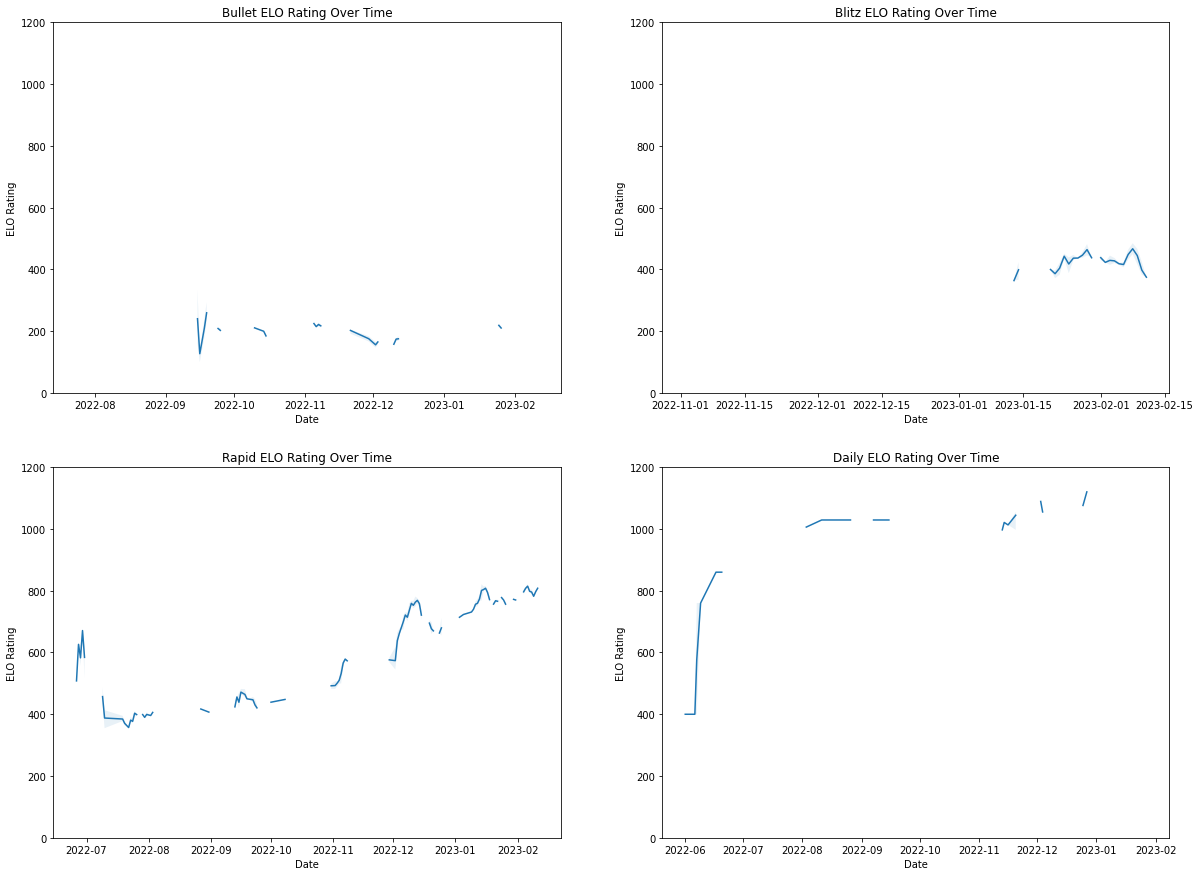

In [184]:
grpd_games = (scored_games.groupby([pd.Grouper(key = 'game_date', freq = "1D"), 'time_category'])
              ['user_elo']
              .agg([np.min, np.max, np.mean]))

grpd_games = pd.pivot_table(grpd_games, index=['game_date'], columns = ['time_category'])
#grpd_games_weekly['amax']['Blitz']
#grpd_games_weekly['amax'].columns
fig, axs = plt.subplots(2, 2, figsize=[20,15])
axs[0, 0].plot(grpd_games.index,
               grpd_games['mean']['Bullet'])
axs[0, 0].fill_between(grpd_games.index,
                       grpd_games['amax']['Bullet'],
                       grpd_games['amin']['Bullet'],
                       alpha=0.10)
axs[0, 0].set_ylim(0, 1200)
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('ELO Rating')
axs[0, 0].set_title("Bullet ELO Rating Over Time")

axs[0, 1].plot(grpd_games.index,
               grpd_games['mean']['Blitz'])
axs[0, 1].fill_between(grpd_games.index,
                       grpd_games['amax']['Blitz'],
                       grpd_games['amin']['Blitz'],
                       alpha=0.10)
axs[0, 1].set_ylim(0, 1200)
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('ELO Rating')
axs[0, 1].set_title("Blitz ELO Rating Over Time")

axs[1, 0].plot(grpd_games.index,
               grpd_games['mean']['Rapid'])
axs[1, 0].fill_between(grpd_games.index,
                       grpd_games['amax']['Rapid'],
                       grpd_games['amin']['Rapid'],
                       alpha=0.10)
axs[1, 0].set_ylim(0, 1200)
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('ELO Rating')
axs[1, 0].set_title("Rapid ELO Rating Over Time")

axs[1, 1].plot(grpd_games.index,
               grpd_games['mean']['Daily'])
axs[1, 1].fill_between(grpd_games.index,
                       grpd_games['amax']['Daily'],
                       grpd_games['amin']['Daily'],
                       alpha=0.10)
axs[1, 1].set_ylim(0, 1200)
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('ELO Rating')
axs[1, 1].set_title("Daily ELO Rating Over Time")

plt.show()

Now let's start looking at blunder and mistakes.

In [13]:
# identify player who made first blunder
# odd numbered move_number_actual = black player move, even numbered move_number_actual = white player move
first_blnd_mist = scored_games[(scored_games['blunder'] == True) | (scored_games['mistake'] == True)].groupby('game_link').first()
first_blnd_mist.loc[first_blnd_mist['move_number_actual'] % 2 == 0, 'first_player_blunder'] = first_blnd_mist['white']
first_blnd_mist.loc[first_blnd_mist['move_number_actual'] % 2 == 1, 'first_player_blunder'] = first_blnd_mist['black']
first_blnd_mist.loc[first_blnd_mist['winner'] == first_blnd_mist['first_player_blunder'], 'first_blunder_loss'] = False
first_blnd_mist.loc[first_blnd_mist['winner'] != first_blnd_mist['first_player_blunder'], 'first_blunder_loss'] = True
#first_blnd_mist[['winner', 'first_player_blunder', 'first_blunder_loss']]
#first_blnd_mist[['winner', 'blunder', 'mistake', 'move_number_actual']]
first_blnd_mist['first_blunder_loss'].value_counts(normalize = True).round(3)*100

True     59.9
False    40.1
Name: first_blunder_loss, dtype: float64

The code above shows that the player that makes the first blunder or mistake is more likely to lose the game. I would guess that at higher levels, the proportions become even more dramatic.

*Note that a game can end without a mistake or blunder being made **and** there is a winner. This happens when someone resigns or times out before a mistake of blunder happens. I know that I have done this and played others that have done this as well. This means that the games above plus draws will not necessarily add up to the total number of games played.*

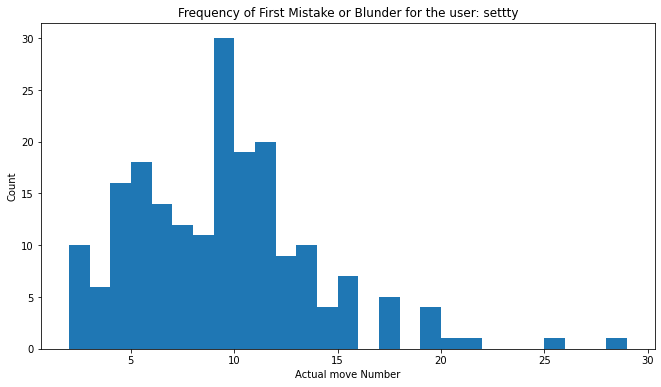

In [14]:
binwidth = 1
user_first_blnd_mist = first_blnd_mist.loc[first_blnd_mist['first_player_blunder'] == user]
#user_first_blnd_mist[['game_date','score','score_change', 'blunder', 'mistake', 'move_number_actual','moves_list']].head()
fig, ax = plt.subplots(figsize=(11, 6))
ax.hist(data = user_first_blnd_mist, x = 'move_number_actual', 
        bins = np.arange(min(user_first_blnd_mist['move_number_actual']),
                         max(user_first_blnd_mist['move_number_actual']) + binwidth,
                         binwidth)
       )
ax.set_xlabel('Actual move Number')
ax.set_ylabel('Count')
ax.set_title('Frequency of First Mistake or Blunder for the user: '+ user)

plt.show()

In [15]:
# get the average move number where the user makes their first mistake or blunder
num_games_week = (scored_games.groupby(pd.Grouper(key = 'game_date', freq = "1W"))
                  ['game_link']
                  .agg(num_games = pd.Series.nunique))

user_first_blnd_mist_week = (user_first_blnd_mist.groupby(pd.Grouper(key = 'game_date', freq = "1W"))
                             .agg(min_first_blnd_mist = ('move_number', 'min'),
                                 mean_first_blnd_mist = ('move_number', 'mean'),
                                 max_first_blnd_mist = ('move_number', 'max')))
#user_first_blnd_mist_week
user_first_blnd_mist_week = user_first_blnd_mist_week.join(num_games_week)

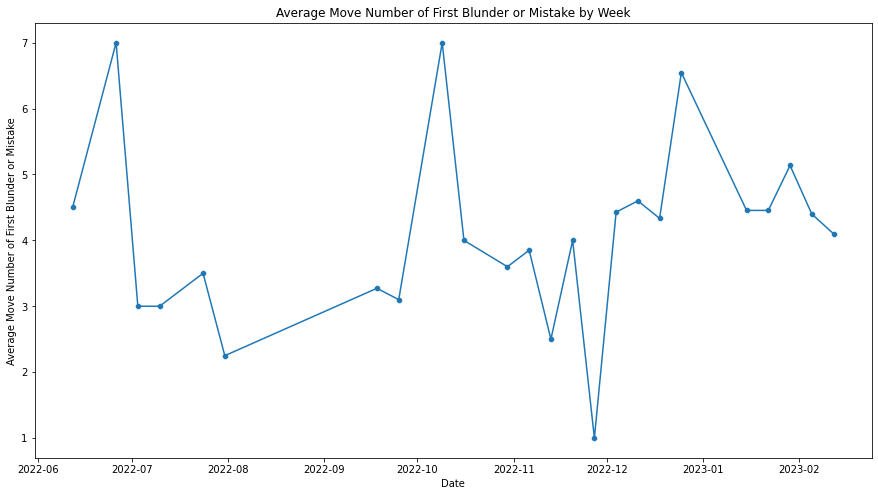

In [34]:
first_blnd = sns.scatterplot(data = user_first_blnd_mist_week, x = 'game_date', y = 'mean_first_blnd_mist')
first_blnd = sns.lineplot(data = user_first_blnd_mist_week, x = 'game_date', y = 'mean_first_blnd_mist')
first_blnd.set(xlabel = "Date",
               ylabel = "Average Move Number of First Blunder or Mistake",
               title = "Average Move Number of First Blunder or Mistake by Week")

plt.gcf().set_size_inches(15, 8)

In [16]:
# calculate the number of games played by week
num_games_week = (scored_games.groupby(pd.Grouper(key = 'game_date', freq = "1W"))
                  ['game_link']
                  .agg(num_games = pd.Series.nunique))

# calculate the number of mistakes or blunders made by the user
# first filter by moves where the user of interest made the move and the move was either a blunder or a mistake
num_games_blnd_mist_week = (scored_games.loc[(scored_games['player_move'] == user) & ((scored_games['blunder']) | (scored_games['mistake']))]
                            # group by week
                            .groupby(pd.Grouper(key = 'game_date', freq = "1W"))
                            # select the blunder and mistake columns
                            [['blunder', 'mistake']]
                            # aggregate by
                            .agg({'blunder':'sum','mistake':'sum'}))
num_games_blnd_mist_week['blnd_mist'] = num_games_blnd_mist_week['blunder'] + num_games_blnd_mist_week['mistake']

weekly_blnd_mist_summary = num_games_blnd_mist_week.join(num_games_week)
weekly_blnd_mist_summary['blnd_mist_game_avg'] = weekly_blnd_mist_summary['blnd_mist'] / weekly_blnd_mist_summary['num_games']
weekly_blnd_mist_summary

,blunder,mistake,blnd_mist,num_games,blnd_mist_game_avg
game_date,,,,,
2022-06-12,9,11,20,4,5.000000
2022-06-19,4,5,9,1,9.000000
2022-06-26,14,13,27,2,13.500000
2022-07-03,65,46,111,10,11.100000
2022-07-10,41,42,83,10,8.300000
2022-07-17,0,0,0,0,NaN
2022-07-24,99,87,186,15,12.400000
2022-07-31,61,78,139,14,9.928571
2022-08-07,19,22,41,3,13.666667


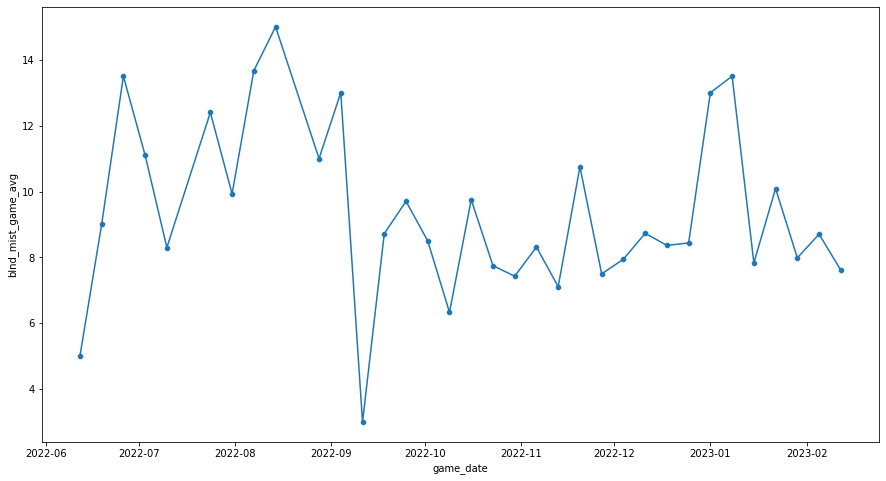

In [36]:
weekly_blnds = sns.scatterplot(data = weekly_blnd_mist_summary, x = 'game_date', y = 'blnd_mist_game_avg')
weekly_blnds = sns.lineplot(data = weekly_blnd_mist_summary, x = 'game_date', y = 'blnd_mist_game_avg')
#weekly_blnds = sns.lineplot(data = weekly_blnd_mist_summary, x = "game_date", y = 'blunder', color = "red")
#weekly_blnds = sns.lineplot(data = weekly_blnd_mist_summary, x = "game_date", y = 'mistake', color = "green")
#plt.plot(weekly_blnd_mist_summary.index, weekly_blnd_mist_summary['blnd_mist_game_avg'])

plt.gcf().set_size_inches(15, 8)

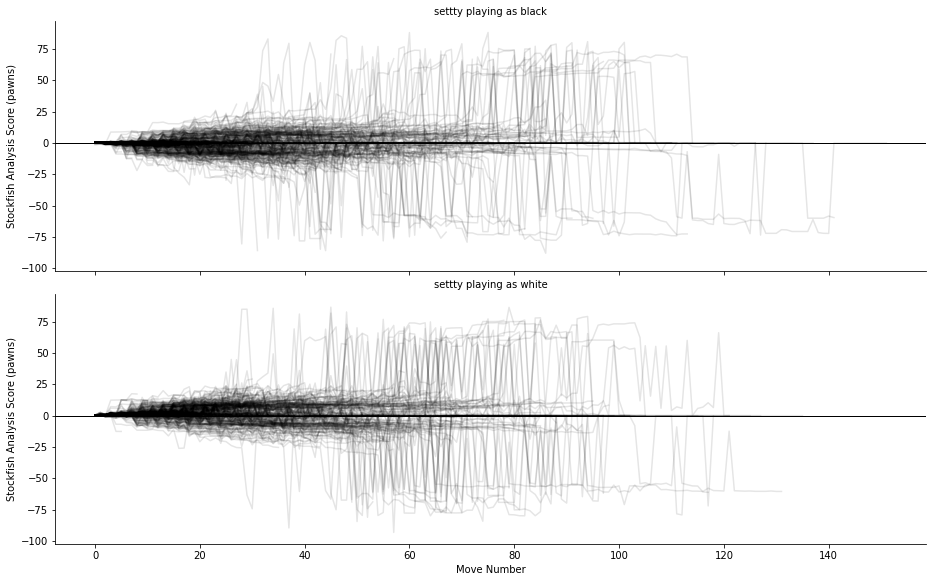

In [17]:
palette = sns.color_palette(['black'], len(scored_games['end_time'].unique()))

game_plot = sns.relplot(data = scored_games,
                        x = "move_number_actual",
                        y = "score",
                        hue='end_time',
                        row = "user_color",
                        kind="line",
                        alpha = 0.1,
                        palette=palette,
                        legend=False)

# set the x and y labels
game_plot.set(xlabel = "Move Number",
              ylabel = "Stockfish Analysis Score (pawns)")

# set the titles of both the charts to the user and color
game_plot.set_titles(user + ' playing as {row_name}')

# add horizontal black line at y = 0, to both plots
axes = game_plot.axes.flatten()
for ax in axes:
    ax.axhline(0, color = "black", linewidth = 1)
   
plt.gcf().set_size_inches(15, 8)

# code below fills above line
#game_plot.fill_between(first_game_copy['move_number_actual'],
#                      first_game_copy['score'], where = first_game_copy['score'] < 0,
#                      color="black", alpha = 0.3)